## Assignment 3
### 19_ \<a1713814>

### 1. Reading dataset and pre-processing

In [1]:
import pandas as pd
import os
import os.path
import spacy
import tqdm
import pickle
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm


import warnings
warnings.filterwarnings("ignore")

/home/crossing/miniconda3/envs/scispacy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-09 14:35:25.237573: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-09 14:35:26.575253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-09 14:35:26.575510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA nod

The original dataset on Kaggle huge, which contains 1056660 samples. To make this runable on my local pc, I randomly sampled 10,000 samples from the original dataset on Kaggle Notebook online, so I don't need to download the whole 20GB.
 Since I sampled these online, I am going to describe how I sampled the data and what attributes I chose. Here are the detailed steps of how I sampled 10,000 data in Kaggle Notebook:
1. use random.sample() to select 25,000 article json path
2. read the sampled json get the whole body text, and first 5 bibliographies
3. match the paper_id to metadata.csv to get more useful attributes of the articles, including title, authors, and journal
4. Data cleaning, including remove samples with missing attributes, non-English, and duplicates.
5. Then randomly sampled 10,000 samples from the cleaned data
5. save to a csv file called 'sampled_df.csv' and download this sampled dataset to my local PC

In [2]:
data_path = './sampled_df.csv'
sampled_df = pd.read_csv(data_path, index_col=0) # index_col = 0 -> avoid fist 'unnamed col'
print(f'number of na: {sampled_df.isnull().any().sum()}')
sampled_df.head()

number of na: 0


,paper_id,title,authors,journal,abstract,body_text,bib
0,PMC8419652,Curriculum tinkering in situations of crises a...,"Amin, Nyna; Mahabeer, Pryah",Prospects (Paris),This article interrogates a curriculum recover...,"In this section, we provide an overview of Sou...",['Big policies/small world: An introduction to...
1,PMC8527883,Similarities and Differences in the Acute-Phas...,"Coleman, Celeste; Doyle-Meyers, Lara A.; Russe...",Front Immunol,Understanding SARS-CoV-2 immune pathology is c...,The rapid emergence and dissemination of sever...,['Clinical Characteristics of Coronavirus Dise...
2,PMC7107128,Effect of insoluble fiber supplementation appl...,"Yokhana, J. S.; Parkinson, G.; Frankel, T. L.",Poult Sci,Two experiments were conducted to study effect...,Growth and development in layer pullets during...,"['The estimation of pepsin, trypsin, papain, a..."
3,PMC7972757,Narrating Arabic Translation Online: Another P...,"Alonayq, Abdulmohsen",When Translation Goes Digital,This chapter takes a socionarrative approach t...,The translation sector has seen an increase in...,"['Arabic tradition', 'The narrative constructi..."
4,PMC8834262,Roles of Podoplanin in Malignant Progression o...,"Suzuki, Hiroyuki; Kaneko, Mika K.; Kato, Yukinari",Cells,Podoplanin (PDPN) is a cell-surface mucin-like...,Podoplanin (PDPN)/T1α/E11 antigen/PA2.26 antig...,['Podoplanin: An emerging cancer biomarker and...


In [3]:
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
from ast import literal_eval

# only need to download these 3 once
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
def pre_processing(df):
    path = './processed_df.csv'
    if not os.path.isfile(path):
        df_c = df.copy()
        #no punctuation or non-alphanumeric chars except periods
        df_c['body_text'] = df_c.body_text.str.replace('[^A-Za-z0-9\s+\-+\.]',' ') #replace special character with a space
        df_c['abstract'] = df_c.abstract.str.replace('[^A-Za-z0-9\s+\-+\.]',' ') #replace special character with a space

        # remove in-text reference e.g., [3-4]
        df_c['body_text'] = df_c.body_text.str.replace('\[.*?\]',' ')

        # remove new lines and back slash
        df_c['body_text'] = df_c.body_text.str.replace('\n',' ')
        df_c['body_text'] = df_c.body_text.str.replace('\s+',' ')

        df_c['abstract'] = df_c.abstract.str.replace('\n',' ')
        df_c['abstract'] = df_c.abstract.str.replace('\s+',' ')

        # no stopwords
        stops = stopwords.words('english') # english stopwords, because our data is in english
        df_c['body_text'] = df_c.body_text.apply(lambda x: " ".join([word for word in x.split() if word not in stops]))
        df_c['abstract'] = df_c.abstract.apply(lambda x: " ".join([word for word in x.split() if word not in stops]))

        df_c['authors'] = df_c.authors.apply(lambda x: x.split(';'))
        df_c['authors'] = df_c.authors.apply(lambda x: [name.strip() for name in x if name.strip() != ''])

        df_c['paper_identifier'] = df_c['paper_id']
        df_c['paper_id'] = [i for i in range(df_c.shape[0])]

        # keep the original body text and abstract for showing IR result
        df_c['original_body_text'] = df['body_text'].copy()
        df_c['original_abstract'] = df['abstract'].copy()


        # save to csv file (pre-process is time-consuming, avoid processing everytime)
        df_c.to_csv(path)
    else:
        df_c = pd.read_csv(path,index_col=0,converters={"bib": literal_eval,"authors": literal_eval}) # body-text col is list of sentences

    return df_c

processed_df = pre_processing(sampled_df)

processed_df.head(5)

,paper_id,title,authors,journal,abstract,body_text,bib,paper_identifier,original_body_text,original_abstract
0,0,Curriculum tinkering in situations of crises a...,"[Amin, Nyna, Mahabeer, Pryah]",Prospects (Paris),This article interrogates curriculum recovery ...,In section provide overview South Africa demog...,[Big policies/small world: An introduction to ...,PMC8419652,"In this section, we provide an overview of Sou...",This article interrogates a curriculum recover...
1,1,Similarities and Differences in the Acute-Phas...,"[Coleman, Celeste, Doyle-Meyers, Lara A., Russ...",Front Immunol,Understanding SARS-CoV-2 immune pathology crit...,The rapid emergence dissemination severe acute...,[Clinical Characteristics of Coronavirus Disea...,PMC8527883,The rapid emergence and dissemination of sever...,Understanding SARS-CoV-2 immune pathology is c...
2,2,Effect of insoluble fiber supplementation appl...,"[Yokhana, J. S., Parkinson, G., Frankel, T. L.]",Poult Sci,Two experiments conducted study effects dietar...,Growth development layer pullets rearing early...,"[The estimation of pepsin, trypsin, papain, an...",PMC7107128,Growth and development in layer pullets during...,Two experiments were conducted to study effect...
3,3,Narrating Arabic Translation Online: Another P...,"[Alonayq, Abdulmohsen]",When Translation Goes Digital,This chapter takes socionarrative approach exa...,The translation sector seen increase volunteer...,"[Arabic tradition, The narrative construction ...",PMC7972757,The translation sector has seen an increase in...,This chapter takes a socionarrative approach t...
4,4,Roles of Podoplanin in Malignant Progression o...,"[Suzuki, Hiroyuki, Kaneko, Mika K., Kato, Yuki...",Cells,Podoplanin PDPN cell-surface mucin-like glycop...,Podoplanin PDPN T1 E11 antigen PA2.26 antigen ...,[Podoplanin: An emerging cancer biomarker and ...,PMC8834262,Podoplanin (PDPN)/T1α/E11 antigen/PA2.26 antig...,Podoplanin (PDPN) is a cell-surface mucin-like...


In the pre-processing step, I processed on body text, abstract, and authors. The detailed steps are as follows:
1. Removed non-alphanumeric chars (except '-' and '.'): Because they are most likely to be greek letters that used in the equations or experiment variables, which is not informative in out task. However, '-' used a lot in medical named entities, such as 'COVID-19', 'SARS-CoV-2', 'whole-blood', therefore, I did not remove '-'. Otherwise it would have negative impact on the performance of NER and thus the following downstream tasks. Also '.' is useful for differntiate sentences when perform summarization.

2. Removed in-text references, new lines, back slashes and stopwords, because they are not informative, and removing them will not affect the NER and other following downstream tasks.

3. Processed authors from a string containing all names seperated by ';" to a list of individual's name (using .split(';'))

4. Renamed the 'paper_id' to 'paper_identifier', and use the index of the sample to be the 'paper_id'

Some Notes:

- I did not perform lowercasing here, because in biomedical cases there are a lot of abbreviations, which will be specifically resolved in the entity linker pipeline when building the KB.
- I also didn't perform lemmatization nor stemming, because they might modify the named entity, and would be difficult to be recognized by the NER model. Also, lemmatization and stemming works on token level, but there are named entities consist of multiple word tokens, and modified a token in a named entity phrase would affect the NER and the following downstream tasks.For example, 'lung kidney lymphatic vascular systems', 'lymphatic' will be stemmed to 'lymphat'.
- I did not convert the text to BOW as the assignment spec 1.c said, because I will use scispacy to perform NER, which takes text as input. And also in the 'assignment tips' and assignment specification step 4 (d), we are encouraged to use word embeddings, so I am not using BOW to vectorise the text in this assignment.

### 2. Named Entity Recognition and Knowledge Base

In [4]:
# ! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz
# ! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

from scispacy.linking import EntityLinker
class Knowledge_Base:
    def __init__(self, processed_df):
        self.processed_df = processed_df

        # init nlp model, model will be loaded when bulding kb
        self.nlp = None

        # init kb, or load kb if it's already built
        self.kb = None
        self.kb_path = 'knowledge_base.pkl'
        if os.path.isfile(self.kb_path):
            with open(self.kb_path, 'rb') as kb_pickled:
                self.kb = pickle.load(kb_pickled)
        else:
            self.build_KB_with_entities()

    def __init_nlp(self):
        self.nlp = spacy.load("en_core_sci_sm") # for NER #en_ner_bc5cdr_md #en_core_sci_sm

        # k=1: return the top candidate (concept with the highest score)
        # default score thresh = 0.7, but change to 0.8
        # umls: Unified Medical Language System.
        self.nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls", 'k':1, 'threshold':0.8}) # for getting canonical name and aliases
        return

    def __init_KB(self):
        # This function only pre-process the paper and author part.
        kb = {'paper':{id_str:{} for id_str in self.processed_df['paper_id'].tolist()}}
        authors_dict = {}
        for id,dic in tqdm.tqdm(kb['paper'].items(), desc = 'Initialize KB', unit = ' article'):
            title = self.processed_df.loc[self.processed_df['paper_id']==id]['title'].values[0]
            dic.update({'title':title})

            authors_lst = self.processed_df.loc[self.processed_df['paper_id']==id]['authors'].values[0]
            dic.update({'authors':authors_lst})

            for author in authors_lst:
                if author not in authors_dict.keys():
                    authors_dict.update({author:{'paper_lst':{id}}})
                else:
                    authors_dict[author]['paper_lst'].add(id)

        kb.update({'authors':authors_dict})

        # init entity part for futher entity related processes
        kb.update({'entities':{}})
        return kb

    def __update_entity_dict(self,entity_dict,doc,linker,paper_id):
        for entity in doc.ents: # for each recognised entities
            for umls_ent in entity._.kb_ents: # for each matched umls concept matched
                # 'umls_ent[0]' is the concept entity with the highest score
                concept_id = (linker.kb.cui_to_entity[umls_ent[0]]).concept_id
                canonical_name = (linker.kb.cui_to_entity[umls_ent[0]]).canonical_name
                definition = (linker.kb.cui_to_entity[umls_ent[0]]).definition
                if len((linker.kb.cui_to_entity[umls_ent[0]]).aliases) == 0:
                    umls_aliases_set = set()
                else:
                    umls_aliases_set = set((linker.kb.cui_to_entity[umls_ent[0]]).aliases)

                entity_name = (entity.text).strip()

                # if this a new entity for both current KB and this paper
                if canonical_name not in self.kb['entities'].keys() and canonical_name not in entity_dict.keys():
                    if entity.text != canonical_name:
                        umls_aliases_set.add(entity_name)

                    # entity_dict.update({canonical_name:{'cid': concept_id, 'definition':definition, 'aliases':umls_aliases_set, 'paper_lst':{paper_id}}})
                    entity_dict.update({canonical_name:{'cid': concept_id, 'definition':definition, 'aliases':umls_aliases_set, 'paper_lst':{paper_id},'tf_lst':[[paper_id,1]]}})#*

                # if it both in kb and the paper, just +1 in term freq
                elif canonical_name in self.kb['entities'].keys() and canonical_name in entity_dict.keys():
                    for i,tf_lst in enumerate(entity_dict[canonical_name]['tf_lst']):
                        if tf_lst[0] == paper_id:
                            entity_dict[canonical_name]['tf_lst'][i][1] = entity_dict[canonical_name]['tf_lst'][i][1]+1
                            break

                # if this entity not in the KB but in this paper
                elif canonical_name not in self.kb['entities'].keys() and canonical_name in entity_dict.keys():
                    entity_dict[canonical_name]['paper_lst'].add(paper_id)
                    for i,tf_lst in enumerate(entity_dict[canonical_name]['tf_lst']):
                        if tf_lst[0] == paper_id:
                            entity_dict[canonical_name]['tf_lst'][i][1] = entity_dict[canonical_name]['tf_lst'][i][1]+1
                            break
                    # entity_dict[canonical_name]['tf_lst'][paper_id] = entity_dict[canonical_name]['tf_lst'][paper_id] +1 #*
                    if entity_name != canonical_name:
                        entity_dict[canonical_name]['aliases'].add(entity_name)


                # if this entity appears in th KB, but new to this paper
                elif canonical_name in self.kb['entities'].keys() and canonical_name not in entity_dict.keys():
                    self.kb['entities'][canonical_name]['paper_lst'].add(paper_id)
                    self.kb['entities'][canonical_name]['tf_lst'].append([paper_id,1])

                    # self.kb['entities'][canonical_name]['tf_lst'][paper_id] = self.kb['entities'][canonical_name]['tf_lst'][paper_id] + 1
                    if entity_name != canonical_name:
                        self.kb['entities'][canonical_name]['aliases'].add(entity_name)
                    entity_dict.update(self.kb['entities'][canonical_name])

        return entity_dict

    def __build_all_entity_dict(self,text,title,paper_id,body_text):
        # This function is keeping updating this paper's entity dictionary
        # during process paper's title, abstract and the first 500 and last 500 words in body text
        entity_dict = {}
        linker = self.nlp.get_pipe("scispacy_linker")
        text_doc = self.nlp(text)
        entity_dict.update(self.__update_entity_dict(entity_dict,text_doc,linker,paper_id))

        title_doc = self.nlp(title)
        entity_dict.update(self.__update_entity_dict(entity_dict,title_doc,linker,paper_id))

        body_text_doc = self.nlp(body_text)
        entity_dict.update(self.__update_entity_dict(entity_dict,body_text_doc,linker,paper_id))

        return entity_dict

    def build_KB_with_entities(self):
        self.kb = self.__init_KB()
        self.__init_nlp()

        for paper_id,paper_dict in tqdm.tqdm(self.kb['paper'].items(), desc = 'Building entities', unit = ' article'):
            abstract = self.processed_df.loc[self.processed_df['paper_id']==paper_id]['abstract'].values[0]
            title = paper_dict['title']
            # only process the 1st 500 and the last 500 words in the body text,
            # these might be the introduction and the conclusion of the article, which is more representative of this paper
            body_text = self.processed_df.loc[self.processed_df['paper_id']==paper_id]['body_text'].values[0]
            body_text_intro = ' '.join(body_text.split()[:500])
            body_text_conclu = ' '.join(body_text.split()[-500:])
            sampled_body_text = body_text_intro + body_text_conclu

            entity_dict = self.__build_all_entity_dict(abstract, title,paper_id, sampled_body_text)
            for k in ['cid', 'definition', 'aliases', 'paper_lst']:
                entity_dict.pop(k, None)
            self.kb['entities'].update(entity_dict)
            paper_dict.update({'entities': list(entity_dict.keys())})
        for canonical in self.kb['entities'].keys():
            temp = []
            if isinstance(self.kb['entities'][canonical],dict):
                for tf_lst in self.kb['entities'][canonical]['tf_lst']:
                    if len(temp) == 0:
                        temp.append(tf_lst)
                    else:
                        if tf_lst[0] == temp[-1][0]:
                            temp[-1][1] = temp[-1][1]+1
                        else:
                            temp.append(tf_lst)
                self.kb['entities'][canonical].update({'tf_lst':temp})
        self.kb['entities'].pop('tf_lst')
        self.__save_kb()
        return

    def __save_kb(self):
        with open(self.kb_path,'wb') as kb_pickled:
            pickle.dump(self.kb,kb_pickled)
            print('Knowledge base saved successfully!')
        return


k = Knowledge_Base(processed_df)
KB = k.kb

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


#### The structure of my knowledge base:

```
├── KB
    ├── 'paper'
        ├── 'paper_id 1'
            ├── 'title' : xxx
            ├── 'authors' : [xxx,xxx,...]
            ├── 'entities' : [xxx,xxx,...]
        ├── 'paper_id 2'
            ├── 'title' : xxx
            ├── 'authors' : [xxx,xxx,...]
            ├── 'entities' : [xxx,xxx,...]
        .
        .
        .

    ├── 'authors'
        ├── 'author name 1'
            ├── 'paper_lst' : [xxx,xxx,...]
        ├── 'author name 2'
            ├── 'paper_lst' : [xxx,xxx,...]
        .
        .
        .

    ├── 'entities'
        ├── 'canonical_name 1'
            ├── 'cid' (concept id, or CUI) : xxx
            ├── 'definition' : xxx
            ├── 'aliases' : [xxx,xxx,...]
            ├── 'paper_lst' : [xxx,xxx,...]
            ├── 'tf_lst' : [xxx,xxx,...]
        ├── 'canonical_name 2'
            ├── 'cid' (concept id, or CUI) : xxx
            ├── 'definition' : xxx
            ├── 'aliases' : [xxx,xxx,...]
            ├── 'paper_lst' : [xxx,xxx,...]
            ├── 'tf_lst' : [xxx,xxx,...]
        ├── 'canonical_name 3'
            ├── 'cid' (concept id, or CUI) : xxx
            ├── 'definition' : xxx
            ├── 'aliases' : [xxx,xxx,...]
            ├── 'paper_lst' : [xxx,xxx,...]
            ├── 'tf_lst' : [xxx,xxx,...]
        .
        .
        .
```
In this section, I only processed the paper title, abstract and first 500 words and last 500 words of the body text, because these two parts of the body text can introduce and conclude this paper, which are more representative of the body text. (I tried to process the whole body_text previously, but my computer always froze and could not process all 10000 samples' whole body text, so I sub-sampled the body text to these two parts to represent the whole body text). The process pipeline consists of NER, abbrev resolution, and a further text normalisation using UMLS's concept id (cui). The detailed processing steps are as follows: <br>

I utilized the library sciSpaCy 'en_core_sci_sm' pretrained model to perform Named Entity Recognition, and added extra pipeline ,entity_linker with abbreviation resolution, to link the recognized entity to the UMLS knowledge base, where the 'UMLS' stands for the Unified Medical Language System. The entity linker will link the entity to an external medical knowledge base. In this case, I used UMLS, which contains around 3M biomedical concepts. There are other options of the external knowledge base, such as MESH (Medical Subject Headings, 30K entities), but I am using the UMLS, because it is the largest medical knowledge base in SciSpaCy. In this step, the entity linker will map the recognised entity to the known entity (or concept) in th UMLS. This process will also resolve the abbreviations, by adding "resolve_abbreviations": True. Abbreviation resolution is an important step because abbreviations are commonly exist in biomedical texts. For each recognised entity, I will only link it to the top 1 match (by setting 'k':1), with a threshold of 0.8 (the default thresh is 0.7, but I tuned it up to 0.8, for a more fine-grained output).
Once I match it to a concept entity in UMLS, then I keep its canonical name and other alias recorded in UMLS. If the entities are recognised but not the same as the UMLS canonical name nor any UMLS alias, then this entity name will be added to its alias list as well, and its UMLS canonical name will be the key of this entity entry in the KB. Therefore, during the construction of the KB, the number of entities is growing as the model scanning through the articles, and at the same time, each entities' aliases list are growing too. Furthermore, if the entity is already exist in the KB, its 'paper_lst' is also updated when scanning new articles.

### 3. Indexing method

In [5]:
def generate_inverted_index(KB,processed_df):
    inverted_dict = {}
    # for key in ['authors']:
    for key in ['authors','entities']:
        canonical_lst = list(set(KB[key].keys()))
        for can in canonical_lst:
            inverted_dict.update({can:[]})
            if key == 'entities':
                for id_tf_tupe in KB['entities'][can]['tf_lst']:
                    inverted_dict[can].append(id_tf_tupe)
                    inverted_dict[can].append((paper_id,tf))
            else:
                for paper_id in KB[key][can]['paper_lst']:
                    tf = 1 # author name will only apperar once in the paper
                    inverted_dict[can].append((paper_id,tf))
            inverted_dict[can].sort(key=lambda x: x[0])
    return inverted_dict

inverted_index = generate_inverted_index(KB,processed_df)

In [6]:
print('First 10 paper mentioned COVID-19 (or its aliases): ',[lst[0] for lst in inverted_index['COVID-19'][:10]],'\n')
print('Show 5 article mentioned mRNA Expression (idx): ', [lst[0] for lst in inverted_index['mRNA Expression'][:5]],'\n')
print('Show 5 article mentioned mRNA Expression (title):')
for id in inverted_index['mRNA Expression'][:5]:
    title = processed_df.loc[processed_df['paper_id']==id[0]]['title'].values[0]
    print(title)

print(f' \n len inverted index: {len(inverted_index)}')

First 10 paper mentioned COVID-19 (or its aliases):  [0, 1, 5, 6, 7, 8, 9, 10, 11, 12] 

Show 5 article mentioned mRNA Expression (idx):  [1, 4, 10, 11, 13] 

Show 5 article mentioned mRNA Expression (title):
Similarities and Differences in the Acute-Phase Response to SARS-CoV-2 in Rhesus Macaques and African Green Monkeys
Roles of Podoplanin in Malignant Progression of Tumor
COVID-19: Clinical features, case fatality, and the effect of symptoms on mortality in hospitalized cases in Iran
Coronary Thrombo-Embolic Events after Covid-19 Vaccination- A Single Centre Study
Do suicide rates in children and adolescents change during school closure in Japan? The acute effect of the first wave of COVID-19 pandemic on child and adolescent mental health
 
 len inverted index: 126308


This section, the article indexing method is inverted index by named entities.
<br>
 Each canonical name is a key in inverted_index dictionary, its value is a list of tuples, where each tuple contains a id of the paper that mentioned this entity, and the term frequency of this entity in this paper (tf). By utilizing the information in the KB, it's very efficient to build the inverted index. Because these information can be directly obtained from the KB. Note, the term frequency here is the value after the text normalisation, because the term frequency in the KB considered the UMLS alias and other names mapped to the same UMLS concept as well. <br>

With the help of inverted index, we can significantly reduce the search space during the retrieval of documents.

### 4. Text matching utility

##### GloVe

In [ ]:
# This function will read the clove file, and create a dictionary for our vocabulary
def build_glove_embedding_dict():
    glove_final_dict_path = 'glove_final_dict.pkl'
    if os.path.isfile(glove_final_dict_path):
        with open(glove_final_dict_path, 'rb') as kb_pickled:
            embedding_vector = pickle.load(kb_pickled)
    else:
        WV_PATH = 'glove.840B.300d.txt'
        embedding_vector = {}
        f = open(WV_PATH,encoding="utf8") #embedding dim = 300
        for line in tqdm.tqdm(f,desc = 'Building word vector dictionary'):
            value = line.split(' ')
            word = value[0]
            coef = np.array(value[1:],dtype = 'float32')
            embedding_vector[word] = coef
        f.close()
        print('Loaded %s word vectors.' % len(embedding_vector))
        with open(glove_final_dict_path,'wb') as f_pickled:
            pickle.dump(embedding_vector,f_pickled)
            print('glove_final_dict saved successfully!')
    return embedding_vector

glove_dict = build_glove_embedding_dict()

I used the pre-trained embedding layer GloVe 840B 300d.(download through: https://nlp.stanford.edu/projects/glove/) GloVe is pre-trained to capture the context of the word in the embedding through explicitly capturing the co-occurrence probability. It aims to be built not just on the word probabilities, but their co-occurrence probabilities within the context, and this is used in its loss function in its pre-train process. <br>

Steps: <br>
Download Glove, open the text file, and create a dictionary with word as a key and its corresponding embedding vector as its value. <br>

Note: I found GloVe is not very good when working with biomedical text, because GloVe is not sufficiently trained on biomedical texts. For example, the Glove I am using (840B 300d) was just trained on common crawled text. There are many medical word not in Glove Embedding

##### Check the percentage of words mentioned in KB and also exists in GloVe

In [ ]:
def check_glove_available_percentage(glove_dict,KB):
    all_ent = []
    for can in list(set(KB['entities'].keys())):
        all_ent.append(can)
        alias_lst = list(KB['entities'][can]['aliases'])
        all_ent.extend(alias_lst)
    unique_token = list({token for ent in all_ent for token in ent.split(' ')})
    num_token_exist = 0
    for token in unique_token:
        if token in glove_dict.keys():
            num_token_exist += 1
    percent = num_token_exist/len(unique_token)
    print(f"There are {len(unique_token)} tokens exist in the KB, and {num_token_exist} of these tokens are available in GloVe ({round(percent*100,2)}% vocabulary availabel in GloVe)")
    return
check_glove_available_percentage(glove_dict,KB)

The lack of medical vocabulary is the major drawback of using GloVe embedding in this assignment. However, using pretrained word embedding is asked in the assignment step 4(d). Therefore, I am still going to implement my IR system using GloVe. Furthermore, integrating the pre-trained word embedding into the Information Retrival System can generally improve the performance of the retrival, because TF-IDF cannot imply the semantic similarity, whereas, the pre-trained word embeddings learned the semantic meaning of the words over a large amount of text. Therefore, I am going to integrate GloVe into the IR System.
<br>
Potential Improvement: <br>
1. It's better to use a word embedding that can capture more medical terms' meanings, instead of using general-purpose word embedding GloVe. I did some research on this and found a publically available biomedical word embedding 'cui2vec' (GitHub: https://github.com/beamandrew/cui2vec , download: https://figshare.com/s/00d69861786cd0156d81 , paper: https://arxiv.org/abs/1804.01486 ). 'cui2vec' can map UMLS concept unique identifier (cui) to a vector. This implies 'cui2vec' word embedding is highly aligned and consistent with our knowledge base that is built with UMLS concepts as well. However, 'cui2vec' does not cover a lot of the entity concepts that are in out CORD-19 article KB (only 32.43% available, which is even worse than GloVe. 'cui2vec' is in entity phrase levels, GloVe is in word token level, but generally speaking, 32.43% in entity level is worse than 44.63% in token level, because even there is one unknown word in a medical phrase, but if we can embed other tokens, the model can still contain partial information of this token). Other than 'cui2vec', there is an available 'BioWordVec'. 'BioWordVec' is a biomedical word embedding pre-trained on PubMed+MIMIC-III using FastText, but this embedding is too big (13GB) for my local computer. Therefore, I am going to use GloVe embedding, which can be used on my local PC, and also covers larger amount of medical terms compared with 'cui2vec'. However, if I have a computer with better computation power and bigger memory, I will definitely give 'BioWordVec' a try.
<br>

2. Due to the lack of coverage of medical terminologies in GloVe embedding, I am going to use both TF-IDF and pre-trained GloVe word embeddings in my IR system. By combining these two scores, the retrival performance can be more robust, especially in the cases of out-of-vocabulary in GloVe. The detailed implementation of my IR system as follows:

- query pre-processing:
    - In my IR system, I pre-process the query by removing the stopwords. Then perform NER by using two models, one is 'en_core_sci_sm' for medical entity recognition, and 'en_core_web_sm' for general named entity recognition. This is because the SciSpaCy medical NER model are not good at recognising general entities, such as, author names, etc. Therefore, we also need a general NER model too.
- matching common entities and get the posting list to reduce the paper search space:
    - if the entity in the query is matched to a canonical name in the inverted index key, then we store this entity for further embedding and tf-idf computation, also get id of the articles mentioned this entity.
    - if this entity in the query is an alias (other associated names) of a canonical name, then we will get its canonical name. Then do the same steps above.
    - If query entity is neither a canonical name nor an alias, then I compute the cosine similarity of this query entity with all the canonical names in the inverted index. if all the similarities are < 0.7, it won't match to any doc canonical entities, and we will ignore this query entity. Otherwise, the query entity will match to the canonical name with the highest similarity score. (This text normalisation step can also be done with the scispacy UMLS entitylinker, but it's a very heavy model, and it is very time-consuming. Therefore, I am utilising the cosine similarity of the embedding to perform the soft match. Normalising the query text is important, because there will be query entities that are neither the canonical name nor the known aliases in the KB, but they might describe the same concept. Using cosine similarity to perform the soft match can mitigate this issue)
    - Finally, the query will be represented by these matched entities, and at the same time we also obtained a reduced doc search space from inverted index method
- Compute the score for all the doc in the reduced search space
    - The score of the retrival rank contains two parts, the tf-idf and the cosine similarity of the query and document vectors
        - The query and the document are both represented by their recognised entities. If an entity is composed of multiple word tokens, then this entity will be represented as a mean-pooling of all the tokens, therefore, all the entity embeddings are 300d (the dimension is the same as the GloVe embedding for a single token). Then the query embedding and the document embedding vector is the mean-pooling vector of all their recognised entities, so the query and the documents vectors are both 300d.
        - To alleviate the limited medical vocabulary coverage of the GloVe embedding, I utilised both tf-idf and the GloVe embedding cosine similarity.
        - I first standardise the embedding cosine similarity list and the tfidf list both in the range of 0-1. For each document I averaged its standardised tf-idf score and the standardised embedding cosine score, and this average will be the final score of ranking. By doing this, some rare medical words that are not in the GloVe embedding can still obtain some ranking score from tf-idf part. There are some out-of-vocabulary retrival test examples below.
        - Finally, rank the documents based on the scores.

##### The detailed implementation is shown in the code below:

In [ ]:
class Retriever_glove:
    def __init__(self,inverted_index,glove_dict,KB,data_df):
        self.nlp = spacy.load("en_core_sci_sm") # for medical NER on query
        self.nlp_general = spacy.load("en_core_web_sm") # for general NER on query, such as author names, etc
        self.word_embedding = glove_dict
        self.inverted_index = inverted_index
        self.KB = KB
        self.norm_dict = self.__canonical_aliases_normalization()
        self.data_df = data_df
        return

    def __get_vec(self,word):
        if word in self.word_embedding.keys():
            return self.word_embedding.get(word)
        else:
            # if the word is unknown in GloVe, then return a zero vector with the same dim i.e. 300
            return np.zeros(300)

    def __embed_text(self,ent_lst):
        entity_embedding_dict = {}
        for ent in ent_lst:
            # if the entity is a term consists of multiple word tokens, then just avergae it
            if ' ' in ent:
                stack = np.vstack((self.__get_vec(w) for w in ent.split()))
                ent_vector = np.mean(stack,axis = 0)
            else:
                ent_vector = self.__get_vec(ent)
            entity_embedding_dict.update({ent:ent_vector})
        return entity_embedding_dict

    def __canonical_aliases_normalization(self):
        norm_dict = {}
        for can in list(set(self.KB['entities'].keys())):
            for alias in list(self.KB['entities'][can]['aliases']):
                norm_dict.update({alias:can})
        return norm_dict

    def __cal_wv_similarity(self,entity_vec_dict1,entity_vec_dict2):
        # if the text contain multiple entities,
        # then the vector that represents this text is the average of all the entity vector
        for i, embedding_dict in enumerate([entity_vec_dict1,entity_vec_dict2]):
            # if there's no embedding, then return similarity of 0
            if len(embedding_dict) == 0:
                return 0
            if len(embedding_dict) == 1:
                text_vec = list(embedding_dict.values())[0]
            else:
                stack = np.vstack((v for v in embedding_dict.values()))
                text_vec = np.mean(stack,axis = 0)
            if i == 0:
                text_vec1 = text_vec
            else:
                text_vec2 = text_vec

        if norm(text_vec1) == 0 or norm(text_vec2) == 0:
            return 0
        cos_sim = dot(text_vec1, text_vec2)/(norm(text_vec1)*norm(text_vec2))
        return cos_sim

    def __cal_tfidf_similarity(self,matched_ent,paper_id):
        tfidf_score = 0
        for ent in matched_ent:
            if len([ele[1] for ele in self.inverted_index.get(ent) if ele[0] == paper_id]) != 0:
                t_count = [ele[1] for ele in self.inverted_index.get(ent) if ele[0] == paper_id][0]
                tf_w = 1 + math.log10(t_count)
                N = 10000
                df = len(self.KB['entities'][ent]['paper_lst'])
                idf_w = math.log10((N/df))
                tfidf_score += tf_w*idf_w
        # doc_tfidf_norm = self.__get_doc_tfidf_norm(paper_id)
        # tfidf_score = tfidf_score/doc_tfidf_norm
        return tfidf_score

    def __show_result(self,paper_selected):
        for rank in range(1,len(paper_selected)+1):
            idx = rank -1
            snippet = self.data_df.loc[self.data_df['paper_id']==paper_selected[idx][0]]['original_abstract'].values[0]
            title = self.data_df.loc[self.data_df['paper_id']==paper_selected[idx][0]]['title'].values[0]
            authors = self.data_df.loc[self.data_df['paper_id']==paper_selected[idx][0]]['authors'].values[0]
            article_identifier = self.data_df.loc[self.data_df['paper_id']==paper_selected[idx][0]]['paper_identifier'].values[0]
            article_number = self.data_df.loc[self.data_df['paper_id']==paper_selected[idx][0]]['paper_id'].values[0]
            score = paper_selected[idx][1]
            if rank != 1:
                print('\n')
            print(f'------------------------------ Match Ranked {rank} (similarity score: {score})------------------------------')
            print(f'article identifier: {article_identifier},  article number: {article_number} \n')
            print(f'title:  {title} \n')
            print('Authors: ')
            print('; '.join(authors),'\n')
            print('snippet: \n')
            print(snippet)

    def retrive(self,query,show = True):
        stops = stopwords.words('english') # english stopwords, because our data is in english
        query = " ".join([word for word in query.split() if word not in stops])
        query = query.replace('[^A-Za-z0-9\s+\-]',' ')
        q_doc = self.nlp(query)
        q_doc_general = self.nlp_general(query)
        q_entities = list(set([ent.text.strip() for ent in  q_doc.ents] + [ent.text.strip() for ent in  q_doc_general.ents]))
        query_ent_vec_dict = self.__embed_text(q_entities)

        doc_lst = []
        matched_ent = []
        for ent in q_entities:
            # try hard match first
            if ent in self.inverted_index.keys():
                paper_lst = [ele[0] for ele in self.inverted_index.get(ent)]
                doc_lst.extend(paper_lst)
                matched_ent.append(ent)
            elif ent in self.norm_dict.keys():
                can = self.norm_dict[ent]
                paper_lst = [ele[0] for ele in self.inverted_index.get(can)]
                doc_lst.extend(paper_lst)
                matched_ent.append(can)
            # if can't hard match, use word vector to soft match them with a threshold
            else:
                ENT_SOFT_MATCH_THRESH = 0.7
                can_lst = list(set(self.norm_dict.values()))
                sim_lst = []
                for can in can_lst:
                    can_vec_dict = self.__embed_text([can])
                    q_ent_vec_dict = {ent:query_ent_vec_dict[ent]}

                    # if any of these two entities are completely out of vocab in GloVe, skip match them
                    if np.all(can_vec_dict.get(can)==0) or np.all(q_ent_vec_dict.get(ent)==0):
                        continue

                    sim_lst.append(self.__cal_wv_similarity(q_ent_vec_dict,can_vec_dict))
                if len(sim_lst) == 0:
                    continue
                max_sim = max(sim_lst)
                if max_sim > ENT_SOFT_MATCH_THRESH:
                    max_idx = sim_lst.index(max_sim)
                    can = can_lst[max_idx]
                    paper_lst = [ele[0] for ele in self.inverted_index.get(can)]
                    doc_lst.extend(paper_lst)
                    matched_ent.append(can)

        doc_to_be_searched = list(set(doc_lst))
        wv_score = []
        tfidf_score = []
        for paper_id in doc_to_be_searched:
            doc_ent_lst = self.KB['paper'][paper_id]['entities'] + self.KB['paper'][paper_id]['authors']
            doc_ent_vec_dict = self.__embed_text(doc_ent_lst)
            wv_score.append(self.__cal_wv_similarity(doc_ent_vec_dict,query_ent_vec_dict))
            tfidf_score.append(self.__cal_tfidf_similarity(matched_ent,paper_id))

        # standardising the wv similarity score and tfidf score to 0-1 before averaging the two scores
        if len(tfidf_score) == 0 or max(tfidf_score) == min(tfidf_score):
            std_tfidf_score = [0]*len(tfidf_score)
        else:
            std_tfidf_score = [(s - min(tfidf_score))/(max(tfidf_score)-min(tfidf_score)) for s in tfidf_score]

        if len(wv_score) == 0 or max(wv_score) == min(wv_score):
            std_wv_score = [0]*len(wv_score)
        else:
            std_wv_score = [(s - min(wv_score))/(max(wv_score)-min(wv_score)) for s in wv_score]

        # The final retrieval score is the average of the standardised tfidf and the standardised wv cos similarity
        scores_lst = [(glove+tfidf)/2 for glove,tfidf in zip(std_wv_score,std_tfidf_score)]
        scores_arr = np.array(scores_lst)
        ranked_idx = np.argsort(scores_arr)[::-1]
        paper_ranked = [(doc_to_be_searched[idx],scores_arr[idx]) for idx in ranked_idx]
        if len(paper_ranked) == 0:
            print('Sorry, there is no good match :(')
        else:
            if show == True:
                self.__show_result(paper_ranked[:3])
            else:
                return paper_ranked

    def eval(self,queries,labels):
        # this function return mrr metric
        RR_lst = []
        for q,l in zip(queries,labels):
            paper_ranked = self.retrive(q,show = False)
            paper_id_ranked = [tup[0] for tup in paper_ranked]
            if l in paper_id_ranked:
                RR = 1/(paper_id_ranked.index(l)+1) # '+1' here is because we are using the position not the index
            else:
                RR = 0
            RR_lst.append(RR)
        return sum(RR_lst)/len(RR_lst)

IR = Retriever_glove(inverted_index,glove_dict,KB,processed_df)

How useful NER and KB for this task?
- NER: With the help of NER, the number of unique words are significantly reduced and thus improved the time efficiency (without big drop of retrieval performance). Because the conventional IR using inverted index method is utilising all the unique words, which is not a desired method especially when the document collection is huge. After performing NER, the IR system can focus more on the context, so even we reduce the space of inverted index, the IR system can still maintain a good performance. Furthermore, using unique words will break the entity phrases apart, and twisted the representation of the original meaning. Therefore, we need NER to maintain the integrity of the context.
- KB: The Knowledge base enable an easy implementation of the retrieval system by collecting all the crucial information of the document collection. In the KB, each document is represented as its entities, so people do not need to go through the entire text. The most important part of KB is the storage of canonical names and the associated aliases for text normalisation. In real life, the ways of conveying the same concept in natural language could be various. And text normalisation could enable the IR system to capture the concepts correctly under these variations.

In [ ]:
query = 'what are the symptoms of covid19?'
IR.retrive(query)

- By reading and analysing the text snippet myself, I found these top 2 articles are highly relevant to the symptoms of COVID, the performance of retrival is really well. For example, the 1st one talks about the possible psychosis symptoms of covid, e.g.'patients with a novel corona virus had psychotic symptoms, including hallucination in different forms of modality, delusion, disorganized speech, and grossly disorganized or catatonic behaviors'. The 2nd article mainly talks about the headache symptoms of covid specifically.

# Summarization -- Duc

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
from nltk.corpus import stopwords
from nltk import tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity


class NLTK_Extractive_Summarizer:
    """
    A class used to summarize texts.
    Attributes
    ----------
    stop_words : set
        a set of stopwords. These are ignored when searching for the most used
        words in the text
    language : str
        the current selected language. The stop words set is language specific
    summary_length : int
        the default number of sentences to use for the summary.
    balance_length : bool
        determines if the sentence weight is weighted based on sentence length
    """

    stop_words = {}
    language = None
    summary_length = 0
    balance_length = False

    def __init__(self, language='english', summary_length=3, balance_length=True):
        """
        :param str language: The language to use, defaults to 'en'
        :param int summary_length: The default number of sentences in summary, defaults to 3
        :param bool balance_length: Balance sentences on length, default to False
        """

        # Set the language to use and set the stop words to the default
        # list provided by NLTK corpus for this language
        self.stop_words = set(stopwords.words(language))
        self.language = language

        # Set the default length for the summaries to be created
        self.summary_length = summary_length

        # Sets the switch if the sentence weights need to weighted on
        # sentence length. This might improve performance if the text
        # contains a variety of short and long sentences.
        self.balance_length = balance_length

    def weighted_sentence(self, text, summary_length=None):
        """
        Summarize the given text based on the weight of sentence
        The language and stop word set have been initialized and are used. If no
        summary length is given as parameter, the default length is used.
        :param (str or list) text: The text to summarize
        :param int summary_length: The number of sentences in summary, optional
        :return (str): A string with the summary of the given text
        """

        # Length of summary to generate, if not specified use default
        if not summary_length:
            summary_length = self.summary_length

        # Make a list of all the sentences in the given text
        sentences = []
        if type(text) == str:
            sentences.extend(tokenize.sent_tokenize(text))
        elif type(text) == list:
            for text_part in text:
                sentences.extend(tokenize.sent_tokenize(text_part))
        else:
            return None


        # Determine for each word, not being a stop word, the number of occurences
        # in the text. This word frequency determines the importance of the word.
        word_weights={}
        for sent in sentences:
            for word in word_tokenize(sent):
                word = word.lower()
                if len(word) > 1 and word not in self.stop_words:
                    if word in word_weights.keys():
                        word_weights[word] += 1
                    else:
                        word_weights[word] = 1

        # The weight of each sentence equals the sum of the word importance for
        # each word in the sentence
        sentence_weights = {}
        for sent in sentences:
            sentence_weights[sent] = 0
            tokens = word_tokenize(sent)
            for word in tokens:
                word = word.lower()
                if word in word_weights.keys():
                    sentence_weights[sent] += word_weights[word]
            if self.balance_length and (len(tokens) > 0):
                sentence_weights[sent] = sentence_weights[sent] / len(tokens)
        highest_weights = sorted(sentence_weights.values())[-summary_length:]


        # The summary consists of the sentences with the highest sentence weight, in the
        # same order as they occur in the original text
        summary = ""
        for sentence, strength in sentence_weights.items():
            if strength in highest_weights:
                summary += sentence + " "
        summary = summary.replace('_', ' ').strip()

        return summary


    def text_rank(self, text, summary_length=None):
        """
        Summarize the given text using text rank algorithm (based on page rank)
        The language and stop word set have been initialized and are used. If no
        summary length is given as parameter, the default length is used.
        :param (str or list) text: The text to summarize
        :param int summary_length: The number of sentences in summary, optional
        :return (str): A string with the summary of the given text
        """

        # Length of summary to generate, if not specified use default
        if not summary_length:
            summary_length = self.summary_length

        # Make a list of all the sentences in the given text
        sentences = []
        if type(text) == str:
            sentences.extend(tokenize.sent_tokenize(text))
        elif type(text) == list:
            for text_part in text:
                sentences.extend(tokenize.sent_tokenize(text_part))
        else:
            return None


        # remove punctuations, numbers and special characters
        clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

        # make alphabets lowercase
        clean_sentences = [s.lower() for s in clean_sentences]

        # function to remove stopwords
        def remove_stopwords(sen):
            sen_new = " ".join([i for i in sen if i not in self.stop_words])
            return sen_new


        # remove stopwords from the sentences
        clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

        # Extract word vectors
        word_embeddings = {}
        with open('glove.6B.100d.txt', encoding='utf-8') as f:
            for line in f.readlines():
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                word_embeddings[word] = coefs


        # Init sentence vectors
        sentence_vectors = []
        for sent in clean_sentences:
            if len(sent) != 0:
                vec = sum([word_embeddings.get(word, np.zeros((100,))) for word in sent.split()]) / (len(sent.split()) + 0.001)
            else:
                vec = np.zeros((100,))
            sentence_vectors.append(vec)

        # similarity matrix
        sim_mat = np.zeros([len(sentences), len(sentences)])

        for i in range(len(sentences)):
            for j in range(len(sentences)):
                if i != j:
                    sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100),
                                                      sentence_vectors[j].reshape(1,100))[0, 0]


        # Compute score
        nx_graph = nx.from_numpy_array(sim_mat)
        scores = nx.pagerank(nx_graph)
        ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

        summ = []
        # Generate summary
        for i in range(summary_length):
            summ.append(ranked_sentences[i][1])
        return " ".join(summ)


    def summarize(self, long_text, summary_length=None, split_at=50, method=1):
        """
        Summarize the long text using two method: weighted sentence and text rank.
        The language and stop word set have been initialized and are used. If no
        summary length is given as parameter, the default length is used.

        :param (str or list) long_text: The long text to summarize
        :param int summary_length: The number of sentences in summary, optional
        :param int split_at: The number of sentences in each text chunk
        :param int method: 1: weighted sentence, 2: text rank

        :return (str): A string with the summary of the given text
        """

        # Length of summary to generate, if not specified use default
        if not summary_length:
            summary_length = self.summary_length

        # Make a list of all the sentences in the given text and split this list
        # in chunks of n sentences, n being the split_at value
        sentences = []
        for sent in tokenize.sent_tokenize(long_text):
            sentences.append(sent)

        chunks = [sentences[x:x+split_at] for x in range(0, len(sentences), split_at)]

        # Choose method applied to summarize
        method_func = self.weighted_sentence if method == 1 else self.text_rank
        summaries = []
        for sentences in chunks:
            summary = method_func(sentences, summary_length)
            summaries.append(summary)

        return " ".join(summaries)

In [20]:
# ! pip install rouge

extractor = NLTK_Extractive_Summarizer(summary_length = 5)
id = 3
text = processed_df.loc[processed_df['paper_id']==id]['original_body_text'].values[0]
target_summ = processed_df.loc[processed_df['paper_id']==id]['abstract'].values[0]
# print(text)
summ = extractor.summarize(text)
print('len body: ',len(text))
print('len: :', len(summ.split()))

from rouge import Rouge
rouge = Rouge()
scores_abstractive = rouge.get_scores(summ, target_summ)
scores_extractive = rouge.get_scores(summ, target_summ)
print('scores_abstractive: ',scores_abstractive)
print('scores_extractive: ',scores_extractive)

len body:  50782
len: : 728
scores_abstractive:  [{'rouge-1': {'r': 0.5737704918032787, 'p': 0.10638297872340426, 'f': 0.17948717684825774}, 'rouge-2': {'r': 0.14634146341463414, 'p': 0.019448946515397084, 'f': 0.03433476187752391}, 'rouge-l': {'r': 0.5245901639344263, 'p': 0.0972644376899696, 'f': 0.16410256146364238}}]
scores_extractive:  [{'rouge-1': {'r': 0.5737704918032787, 'p': 0.10638297872340426, 'f': 0.17948717684825774}, 'rouge-2': {'r': 0.14634146341463414, 'p': 0.019448946515397084, 'f': 0.03433476187752391}, 'rouge-l': {'r': 0.5245901639344263, 'p': 0.0972644376899696, 'f': 0.16410256146364238}}]


# Dataset Preparation

In [4]:
dataset_df = pd.DataFrame()
dataset_df['body_text'] = processed_df['body_text']
dataset_df['target_summary'] = processed_df['abstract']
dataset_df.to_csv('summary_dataset.tsv', sep="\t")

bert_dataset_df = pd.DataFrame()
bert_dataset_df['body_text'] = processed_df.body_text.apply(lambda x: ' '.join(x.split()[:512]))
bert_dataset_df['target_summary'] = processed_df.abstract.apply(lambda x: ' '.join(x.split()[:256]))
bert_dataset_df.to_csv('bert_summary_dataset.tsv', sep="\t")

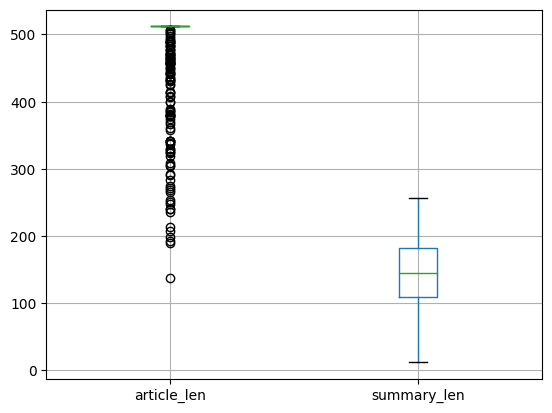

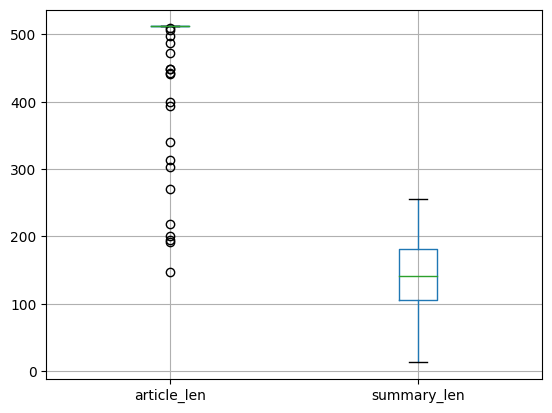

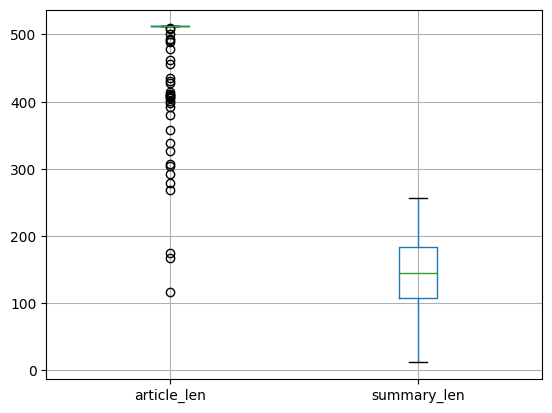

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def data_split(dataset_df):
    x_train, x_test_val, y_train, y_test_val = train_test_split(dataset_df['body_text'], dataset_df['target_summary'], test_size=0.3, random_state=0)
    x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.75, random_state=0)

    bert_train_df = pd.DataFrame()
    bert_train_df['article'] = x_train
    bert_train_df['summary'] = y_train

    bert_val_df = pd.DataFrame()
    bert_val_df['article'] = x_val
    bert_val_df['summary'] = y_val

    bert_test_df = pd.DataFrame()
    bert_test_df['article'] = x_test
    bert_test_df['summary'] = y_test
    return bert_train_df, bert_val_df, bert_test_df

def dataset_statistics(df):
    article_len = df.article.str.split().str.len()
    summary_len = df.summary.str.split().str.len()
    # len_df = pd.DataFrame([article_len,summary_len], columns=['Col1', 'Col2'])
    len_df = pd.DataFrame(dict(s1 = article_len, s2 = summary_len)).reset_index().drop(columns = 'index')
    len_df.columns = ['article_len', 'summary_len']
    boxplot = len_df.boxplot(column=['article_len', 'summary_len'])
    boxplot.plot()
    plt.show()
    return

bert_train_df, bert_val_df, bert_test_df = data_split(bert_dataset_df)
dataset_statistics(bert_train_df)
dataset_statistics(bert_val_df)
dataset_statistics(bert_test_df)

# SciBERT Summarizer -- Sinuo

### Baseline: SciBERT Summarization -- off the shelf pretrained summarization model

In [ ]:
# # !pip install bert-extractive-summarizer==0.4.2
# from summarizer import Summarizer
#
# import torch
# import time
# from transformers import AutoConfig, AutoTokenizer, AutoModel
# # assert torch.cuda.is_available()
#
#
# SUMMARY_RATIO = 0.3
# body_text = processed_df.loc[processed_df['paper_id']==id]['original_body_text'].values[0]
#
# BERTS = ['allenai/scibert_scivocab_uncased']
# # Evaluate custom models.
# for BERT_PATH in BERTS:
#
#   # Load model, model config and tokenizer via Transformers
#   custom_config = AutoConfig.from_pretrained(BERT_PATH)
#   custom_config.output_hidden_states=True
#   print(custom_config)
#   custom_tokenizer = AutoTokenizer.from_pretrained(BERT_PATH)
#   custom_model = AutoModel.from_pretrained(BERT_PATH, config=custom_config)
#   model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)
#
#
#   start = time.time()
#   resp = model(body_text, ratio=SUMMARY_RATIO)
#   end = time.time()
#   print('Model type:', BERT_PATH)
#   print(f'Response Time: {end-start}')
#   # TODO: Split into sentences and pretty-print.
#   print('Summary: ', resp, "\n")

In [21]:
# resp = model(text, ratio=SUMMARY_RATIO)
# print('Summary: ', resp, "\n")

Summary:  The translation sector has seen an increase in volunteer translation thanks to crowdsourcing models and collaborative platforms. New case studies using different methodologies with different sample populations and materials add nuance and depth to extant studies, thereby resulting in a more holistic understanding of volunteer translation. Recourse to a socionarrative approach (Baker 2006) is justified by the fact that most studies analyzing the motivations of volunteer translators tend to employ surveys and/or interviews. It is, however, worth signaling that the inclusion and exclusion of translation organizations in the case study corpus also intersects with narrative framing: a researcher’s narratives and the narratives they have been exposed to can influence what organizations they are aware of and have access to (this intersects with the idea of researcher subjectivity). Personal narratives are the stories we tell ourselves about the world and our own lives; public narrat

In [ ]:
# from summarizer import Summarizer
#
# body = text
# model = Summarizer(custom_model=model, custom_tokenizer=tokenizer)
# model(body)
#
# scores_abstractive = rouge.get_scores(resp, target_summ)
# scores_extractive = rouge.get_scores(resp, target_summ)
# print('scores_abstractive: ',scores_abstractive)
# print('scores_extractive: ',scores_extractive)

### Fine-tuning BERT2BERT Model for CORD19 Article Summarization

In [6]:
import wandb
wandb.login()
wandb.init(
    project = 'SciBERT'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sinuowang. Use `wandb login --relogin` to force relogin


In [6]:
import torch
from transformers import BertTokenizerFast, AutoTokenizer
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


def load_tokenizer(args):
    if not os.path.exists(args.tokenizer_save_path):
        tokenizer = AutoTokenizer.from_pretrained(args.model_name)
        tokenizer.save_pretrained(args.tokenizer_save_path)
        return tokenizer
    return BertTokenizerFast.from_pretrained(args.tokenizer_save_path)


class BERT_Dataset(Dataset):
    # def __init__(self, data_path, data_df, tokenizer, xmax=512, ymax=48, nrows=None):
    def __init__(self, data_df, tokenizer, input_max=512, summary_max=48):
        self.df = data_df
        # self.article = [art_str.split('.') for art_str in data_df['article'].tolist()]
        # self.summary = [summ_str.split('.') for summ_str in data_df['summary'].tolist()]

        self.article = data_df['article'].tolist()
        self.summary = data_df['summary'].tolist()
        self.xmax = input_max
        self.ymax = summary_max
        self.tokenizer = tokenizer

    def encode_str(self, s, lim):
        t = self.tokenizer(s, max_length=lim, truncation=True,
                           padding='max_length', return_tensors='pt')
        return t.input_ids[0], t.attention_mask[0]

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        # x, xmask = self.encode_str(self.df.loc[idx, self.article], self.xmax)
        # y, ymask = self.encode_str(self.df.loc[idx, self.summary], self.ymax)
        x, xmask = self.encode_str(self.article[idx], self.xmax)
        y, ymask = self.encode_str(self.summary[idx], self.ymax)
        labels = y.clone()
        labels = torch.tensor([torch.tensor(-100) if token == self.tokenizer.pad_token_id else token for token in y])
        return {
            'input_ids':x.unsqueeze(0),
            'attention_mask':xmask.unsqueeze(0),
            'labels': labels.unsqueeze(0),
            'decoder_input_ids':y.unsqueeze(0),
            'decoder_attention_mask':ymask.unsqueeze(0)
             }

def create_bert_dataloader(args,data_df, tokenizer,shuffle = True):
    data_loader = DataLoader(
            BERT_Dataset(data_df, tokenizer, input_max=args.input_max, summary_max=args.summary_max),
            batch_size=args.batch_size,
            shuffle=shuffle,
            num_workers=2,
        )
    return data_loader

In [7]:
from transformers import EncoderDecoderModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch.optim as optim
# from config import *
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

from rouge import Rouge
rouge = Rouge()

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    # labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    #
    # rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    res = rouge.get_scores(pred_ids, labels_ids)
    return res



class Trainer():
    def __init__(self, args, tokenizer,train_loader=None, val_loader=None, test_loader=None):
        self.args = args
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader= test_loader
        self.tokenizer = tokenizer
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.__init_model()

    def __init_model(self):
        # set special tokens
        bos_token_id = 101 #cls
        eos_token_id = 102 #sep
        pad_token_id =  0 #PAD
        model = EncoderDecoderModel.from_encoder_decoder_pretrained(self.args.model_name, self.args.model_name)
        model.config.decoder.decoder_start_token_id = bos_token_id #tokenizer.bos_token_id
        model.config.decoder_start_token_id = bos_token_id
        model.config.encoder.bos_token_id = bos_token_id #tokenizer.bos_token_id
        model.config.encoder.eos_token_id = eos_token_id#tokenizer.eos_token_id
        model.config.encoder.pad_token_id = pad_token_id#tokenizer.pad_token_id
        model.config.pad_token_id = pad_token_id

        # unfroze SciBERT encoder
        for name, param in model.named_parameters():
            if 'encoder.encoder' in name or 'encoder.pooler' in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
            # print('name: ',name,'param: ',param.requires_grad)

        # to device: cpu or gpu
        return model.to(self.device)

    def train(self):
        t_total = len(self.train_loader) * self.args.epochs
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.lr, eps=self.args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)


        avg_loss = 0
        for e in range(self.args.epochs):
            for step, batch in enumerate(self.train_loader):
                batch = (v.to(self.device) for k, v in batch.items())
                x, xmask, labels, y, ymask = batch

                outputs = self.model(input_ids=x, attention_mask=xmask,
                                labels=labels, decoder_attention_mask=ymask,
                                return_dict=True)
                loss = outputs.loss
                avg_loss += loss.item() / len(self.train_loader)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                print(f"epoch: {e+1}, loss: {loss.item():.3f}, avg: {avg_loss:.2f}, latest lr: {optimizer.param_groups[0]['lr']}")
        return

    def eval(self,dataloader):
        preds, labels = [], []
        for batch_data in tqdm(dataloader):
            batch_data = batch_data.to(self.device)
            with torch.no_grad():
                generated_tokens = self.model.generate(
                    batch_data["input_ids"],
                    attention_mask=batch_data["attention_mask"],
                    max_length=self.args.summary_max,
                    num_beams=4,
                    no_repeat_ngram_size=2,
                ).cpu().numpy()
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            label_tokens = batch_data["labels"].cpu().numpy()

            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
            decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

            preds += [' '.join(pred.strip()) for pred in decoded_preds]
            labels += [' '.join(label.strip()) for label in decoded_labels]
        scores = rouge.get_scores(hyps=preds, refs=labels, avg=True)
        result = {key: value['f'] * 100 for key, value in scores.items()}
        result['avg'] = np.mean(list(result.values()))
        print(f"Rouge1: {result['rouge-1']:>0.2f} Rouge2: {result['rouge-2']:>0.2f} RougeL: {result['rouge-l']:>0.2f}\n")
        return result


        # training_args = Seq2SeqTrainingArguments(
        #     do_train= True,
        #     do_eval= True,
        #     predict_with_generate=True,
        #     per_device_train_batch_size=self.args.batch_size,
        #     per_device_eval_batch_size=self.args.batch_size,
        #     num_train_epochs = self.args.epochs,
        #     learning_rate= self.args.lr,
        #     weight_decay = self.args.weight_decay,
        #     evaluation_strategy="steps",
        #     fp16=True,
        #     output_dir="./",
        #     overwrite_output_dir=True,
        #     logging_steps=500,
        #     save_steps=500,
        #     eval_steps=self.args.eval_steps,
        #     report_to="wandb",
        # )
        #
        # trainer = Seq2SeqTrainer(
        # model=self.model,
        # tokenizer= self.tokenizer,
        # args=training_args,
        # train_dataset=self.train_loader,
        # eval_dataset=self.val_loader,
        # compute_metrics=compute_metrics,
        # )
        #
        # trainer.train()
        # wandb.finish()




In [8]:
import argparse


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--input_max', default = 512, type=str, help='inputs')
    parser.add_argument('--summary_max', default = 256, type=str, help='labels')
    parser.add_argument('--tokenizer_save_path', type=str, default='./tokenizer')
    parser.add_argument('--model_name', type=str, default="allenai/scibert_scivocab_uncased", help='model name')
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--eval_steps', type=int, default=500)
    parser.add_argument('--weight_decay', type=int, default=0.0)
    parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
    parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.")
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('-f')
    args = parser.parse_args()

    tokenizer_save_path = './bert.tokenizer'
    tokenizer = load_tokenizer(args)

    # bert_trainloader = create_bert_dataloader(args,bert_train_df, tokenizer)
    # bert_valloader = create_bert_dataloader(args,bert_train_df, tokenizer, shuffle = True)
    # bert_testloader = create_bert_dataloader(args,bert_train_df, tokenizer,shuffle = True)

    bert_trainloader = BERT_Dataset(bert_train_df, tokenizer, input_max=args.input_max, summary_max=args.summary_max)
    bert_valloader = BERT_Dataset(bert_train_df, tokenizer, input_max=args.input_max, summary_max=args.summary_max)
    bert_testloader = BERT_Dataset(bert_train_df, tokenizer, input_max=args.input_max, summary_max=args.summary_max),

    trainer = Trainer(args, tokenizer, train_loader=bert_trainloader, val_loader=bert_valloader, test_loader=bert_testloader)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing Ber

In [9]:
trainer.train()

epoch: 1, loss: 12.391, avg: 0.00, latest lr: 9.998571428571429e-05
epoch: 1, loss: 8.970, avg: 0.00, latest lr: 9.997142857142857e-05
epoch: 1, loss: 9.685, avg: 0.00, latest lr: 9.995714285714286e-05
epoch: 1, loss: 9.423, avg: 0.01, latest lr: 9.994285714285715e-05
epoch: 1, loss: 8.165, avg: 0.01, latest lr: 9.992857142857144e-05
epoch: 1, loss: 8.608, avg: 0.01, latest lr: 9.991428571428572e-05
epoch: 1, loss: 8.989, avg: 0.01, latest lr: 9.99e-05
epoch: 1, loss: 8.754, avg: 0.01, latest lr: 9.98857142857143e-05
epoch: 1, loss: 8.806, avg: 0.01, latest lr: 9.987142857142857e-05
epoch: 1, loss: 8.322, avg: 0.01, latest lr: 9.985714285714287e-05
epoch: 1, loss: 8.033, avg: 0.01, latest lr: 9.984285714285715e-05
epoch: 1, loss: 7.550, avg: 0.02, latest lr: 9.982857142857143e-05
epoch: 1, loss: 7.447, avg: 0.02, latest lr: 9.981428571428572e-05
epoch: 1, loss: 8.021, avg: 0.02, latest lr: 9.98e-05
epoch: 1, loss: 8.964, avg: 0.02, latest lr: 9.97857142857143e-05
epoch: 1, loss: 9.188,

5.173477611064909

In [10]:
m = trainer.model

In [14]:
# sample_input = bert_trainloader[3]
# print(f"input text: {tokenizer.decode(sample_input['input_ids'])}")
# res = m(*sample_input)
# res
# # .unsqueeze(0)

idx = 5
input_ids = bert_trainloader[idx]['input_ids'].to('cuda')#.unsqueeze(0).to('cuda')
attention_mask = bert_trainloader[idx]['attention_mask'].to('cuda')#.unsqueeze(0).to('cuda')

# body_text = tokenizer.decode(input_ids, skip_special_tokens=True)
# print(body_text)
outputs = m.generate(input_ids, attention_mask=attention_mask)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
# output = tokenizer.decode(tokens.squeeze(), skip_special_tokens=True)
print('summary: ',summary)
print('outputs: ',outputs, 'len: ', len(outputs[0]))

summary:  introduction the covid 19 pandemic created challenges nursing students. the current pandemic created challenges nursing students
outputs:  tensor([[  101,   102,  2067,   111, 21004,   173,   371, 26196,  4467,  5212,
          7822,  2584,   205,   111,  1073, 26196,  4467,  5212,  7822,  2584]],
       device='cuda:0') len:  20


# Reference

1. T5: https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb
2. BERT2BERT : https://github.com/asceznyk/bert2bert
3. BER2BERT: https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/BERT2BERT_for_CNN_Dailymail.ipynb#scrollTo=68IHmFYLx09W
4. https://colab.research.google.com/drive/1WIk2bxglElfZewOHboPFNj8H44_VAyKE?usp=sharing